In [1]:
%matplotlib notebook
from PyLQR.sim import KDLRobot, TransformedSimulationInterface
from PyLQR.system import PosOrnTimePlannerSys, JointSpaceTimePlannerSys, SequentialSystem, SpacetimeKeypoint, AngularTimeKeypoint
from PyLQR.solver import BatchILQRCP, ILQRRecursive
from PyLQR.utils import primitives, PythonCallbackMessage

import numpy as np
import matplotlib.pyplot as plt

# PyLQR: Combined Task space and joint space planner or tracker example

In this example, we will use a ``SequentialSystem`` to combine a ``PosOrnTimePlannerSys`` and a ``JointSpaceTimePlannerSys``. This will allow us to set targets in both spaces (configuration and task spaces). 

Control command will be joint velocities $\mathbf{\dot{q}}_t$ and the square root of delta t $\sqrt{\text{dt}}$

In [2]:
# Global task variables
dof = 7
nb_state_var = dof+1 # [q,t]
nb_ctrl_var = dof+1  # [dq,sqrt(dt)]
nb_fox_var1 = dof+1 # [pos,orn,t]
nb_fox_var2 = 8 # [q,t]
nb_fox_var = nb_fox_var1 + nb_fox_var2
horizon=500
dt = 0.01
cmd_penalties = [1e-6]*nb_ctrl_var

## Definition of the robot object

The first to do is to create the abstraction of the robot that we want to control. Here we will a robot's abstraction based on the KDL library. The ``KDLRobot`` class requires:

* An URDF file describing the robot that we want to use.
* The name of the base frame in the URDF
* The name of the tip frame in the URDF
* Initial joint configuration

This class will *simulate* the kinematics evolution of the Panda robot in function of the control command that we will send to him.

In [3]:
PATH_TO_URDF = "model.urdf"
BASE_FRAME = "panda_link0"
TIP_FRAME = "panda_tip"
q0 = [ 0.62991112, -0.2329776 , -0.01423721, -1.70254115,  0.06251303, # Initial joint configuration of the robot
        1.50592777,  0.71771416]
dq0 = [0]*dof

qMax = np.array([2.8973,1.7628,2.8973,-0.0698,2.8973,3.7525,2.8973])
qMin = np.array([-2.8973,-1.7628,-2.8973,-3.0718,-2.8973,-0.0175,-2.8973])
rbt = KDLRobot(PATH_TO_URDF,BASE_FRAME,TIP_FRAME,q0,dq0)
transformed_robot1 = TransformedSimulationInterface(rbt,np.identity(4))
transformed_robot2 = TransformedSimulationInterface(rbt,np.identity(4))

## Task & system definition

Now we will define two sub tasks:

* First one will be a joint space task. Abstracted by a ``JointSpaceTimePlannerSys`` that use a list of ``AngularTimeKeypoint`` as keypoints.
* Second one will be a task space task. Abstracted by a ``PosOrnTimePlannerSys`` that use a list of ``SpacetimeKeypoint`` as keypoints.

### Definition of system for System 1

In [4]:
target_1 = np.random.uniform(low=qMin,high=qMax,size=dof)
Qtarget1 = np.identity(dof+1)
Qtarget1[-1,-1] = 0
target1_discrete_time = horizon//2 - 1
target1_continuous_time = 2.5
keypoint_1 = AngularTimeKeypoint(target_1,Qtarget1,target1_continuous_time,target1_discrete_time)

keypoints = [keypoint_1]
cmd_penalties = [1e-5]*nb_ctrl_var
# It is not mandatory to set the limits, if you do not know them yet or do not want to use them. You can use this constructor:
# sys = PosOrnPlannerSys(rbt,keypoints,cmd_penalties,horizon,1,dt)
sys1 = JointSpaceTimePlannerSys(rbt,keypoints,cmd_penalties,qMax,qMin,horizon,1) 

### Definition of system for object 2

In [5]:
target2_pos = np.array([0.554121212377707,      #x (position)
            -0.01575049935289518,  #y (position)
            0.38295604872511507])   #z (position)

target2_orn = np.array([0.014042440828406944,  #w (quaternion)
            0.915047647731553,     #x (quaternion)
            0.4024820607528928,    #y (quaternion)
            0.022333898196169735])  #z (quaternion)

Qtarget2 = np.diag([1, # Tracking the x position
            1, # Tracking the y position
            1, # Tracking the z position
            .1, # Tracking orientation around x axis
            .1, # Tracking orientation around y axis
            .1, # Tracking orientation around z axis
            0]) # Tracking continuous time

target2_continuous_time = 5
target2_discrete_time = horizon - 1

keypoint_2 = SpacetimeKeypoint(target2_pos,target2_orn,Qtarget2,target2_continuous_time,target2_discrete_time)

cmd_penalties = (np.ones(nb_ctrl_var)*1e-5).tolist() # Each control signals have a penalty of 1e-5

keypoints = [keypoint_2]

# It is not mandatory to set the limits, if you do not know them yet or do not want to use them. You can use this constructor:
# sys = PosOrnPlannerSys(rbt,keypoints,cmd_penalties,horizon,1,dt)
sys2 = PosOrnTimePlannerSys(rbt,keypoints,cmd_penalties,qMax,-qMax,horizon,1) 

### Combining both systems

In [6]:
systems = [sys1,sys2]
sys = SequentialSystem(rbt,systems,cmd_penalties,horizon,1)

## Solver definition

Now that the robot and system object are defined, we will define two different solvers to optimize the system:

* A Batch Iterative LQR with control primitives.
* A standard iLQR

Because of the batch formulation, the first one can only be used as a planning algorithm. 
Seconde one can either be used as planning or tracking algorithm (by using either the resulting state sequences or the control gains).

Batch solution use a library of primitives to build the control command:

$$
    \mathbf{u} = \Psi \mathbf{w}
$$

Where $\mathbf{w}$ is the weight of each control primitives. To build the primitives, you can use the ``PyLQR.utils.primitives`` module.

In [7]:
u0_t = np.array([0]*(nb_ctrl_var-1)+[0.1] )
u0 = np.tile(u0_t,horizon-1)

K = 2
psi = primitives.build_psi_unitstep(horizon-1,K)
PSI = np.kron(psi,np.identity(nb_ctrl_var))

# For the batch solution, if you want to use of diagonal elements for Q or special construction of mu,
# you can override targets and precisions set in the system by replacing the 2 lines below by what you want.
# mu = sys.get_mu_vector(False)
# Q = sys.get_Q_matrix(False)

planner1 = BatchILQRCP(sys,PSI)
planner2 = ILQRRecursive(sys)

## Solving the iLQR problem

Now that the solvers have been defined, we will solve the iLQR problem, both solvers will return different things:

- The sparse solver only returns the list of control commands to apply on the robot. To get the joint positions/velocities and task space states, you need to send iteratively these commands to the robot object. Be careful to use the good object in function to what you want (object or robot frame).
- The iterative solver returns the list of: joint states, task space states, control commands, and gains. 
  - Since we are optimizing multiple systems with the ``SequentialSystem`` object, a task_space state is defined as the combination of the task space in all base frames:
  
$$
    f(\mathbf{x}_k) = \lbrack f(\mathbf{x}_k)_A^\top \quad f(\mathbf{x}_k)_B^\top \rbrack^\top
$$

In [8]:
cb = PythonCallbackMessage() # callback to notify python code of the solver evolution

In [9]:
%%time
U1 = planner1.solve(25,u0,False,cb)
U1 = U1.reshape((horizon-1,nb_ctrl_var))
rbt.set_conf(q0,dq0,True)
X1 = np.zeros((horizon,nb_state_var))
F_X1_world_frame = np.zeros((horizon,nb_fox_var1))

t=0
X1[0] = np.hstack((rbt.get_q(),t))
F_X1_world_frame[0] = np.hstack((rbt.get_ee_pos(), rbt.get_ee_orn(),t))

for i in range(horizon-1):
    ut = U1[i]
    dq = ut[:-1]
    dt = ut[-1]**2
    rbt.send_vel(dt,dq,True)
    t += dt
    
    X1[i+1] = np.hstack((rbt.get_q(),t))
    F_X1_world_frame[i+1] = np.hstack((rbt.get_ee_pos(), rbt.get_ee_orn(),t ))

Iteration 1, Cost: 20.5332, alpha= 0.5
Iteration 2, Cost: 15.7077, alpha= 0.5
Iteration 3, Cost: 3.89929, alpha= 0.5
Iteration 4, Cost: 2.9078, alpha= 1
Iteration 5, Cost: 0.936627, alpha= 0.5
Iteration 6, Cost: 0.745731, alpha= 1
Iteration 7, Cost: 0.00617649, alpha= 1
Iteration 8, Cost: 0.00432432, alpha= 1
Iteration 9, Cost: 0.0020289, alpha= 1
Iteration 10, Cost: 0.000815101, alpha= 0.125
Iteration 11, Cost: 0.000800618, alpha= 0.03125
Iteration 12, Cost: 0.000797904, alpha= 0.03125
Iteration 13, Cost: 0.000794957, alpha= 0.03125
Iteration 14, Cost: 0.000790835, alpha= 0.03125
Iteration 15, Cost: 0.000785328, alpha= 0.03125
Iteration 16, Cost: 0.000778554, alpha= 0.0625
Iteration 17, Cost: 0.000777455, alpha= 0.0625
Iteration 18, Cost: 0.000768066, alpha= 0.125
Iteration 19, Cost: 0.000767943, alpha= 0.125
Iteration 20, Cost: 0.000739391, alpha= 0.25
Iteration 21, Cost: 0.000696729, alpha= 1
Iteration 22, Cost: 0.000659245, alpha= 1
Iteration 23, Cost: 0.000517144, alpha= 1
Iterati

In [14]:
%%time
X2,F_X2,U2,K2,k2,cost = planner2.solve(u0.reshape((-1,nb_ctrl_var)),10,True,True,cb)

Iteration 1, Cost: 232.244, alpha= 1, time= 0.0146453
Iteration 2, Cost: 228.563, alpha= 0.0078125, time= 0.0515787
Iteration 3, Cost: 221.501, alpha= 0.015625, time= 0.0438817
Iteration 4, Cost: 218.088, alpha= 0.0078125, time= 0.0490297
Iteration 5, Cost: 214.759, alpha= 0.0078125, time= 0.0497816
Iteration 6, Cost: 213.134, alpha= 0.00390625, time= 0.0558725
Iteration 7, Cost: 211.497, alpha= 0.00390625, time= 0.0540295
Iteration 8, Cost: 208.272, alpha= 0.0078125, time= 0.0421722
Iteration 9, Cost: 206.659, alpha= 0.00390625, time= 0.0547529
Iteration 10, Cost: 203.019, alpha= 0.0078125, time= 0.0433857
CPU times: user 473 ms, sys: 0 ns, total: 473 ms
Wall time: 473 ms


## Plotting

<IPython.core.display.Javascript object>


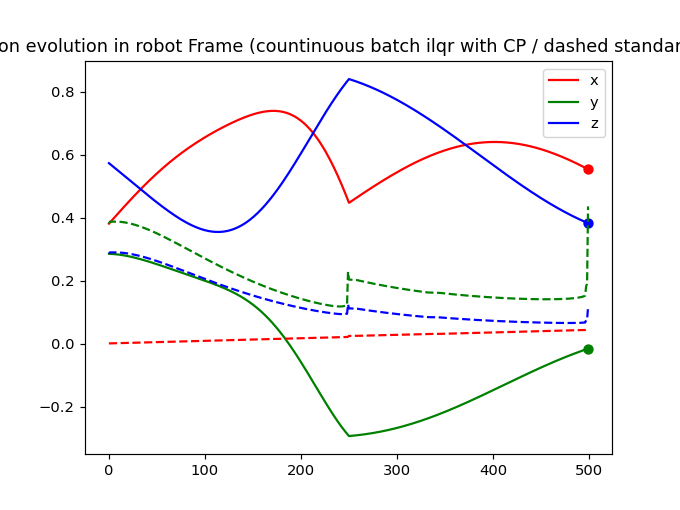

In [11]:
F_X2 = np.asarray(F_X2)

plt.figure()
plt.title('Position evolution in robot Frame (countinuous batch ilqr with CP / dashed standard iLQR)')

plt.plot(F_X1_world_frame[:,0],c='r',label='x')
plt.plot(F_X1_world_frame[:,1],c='g',label='y')
plt.plot(F_X1_world_frame[:,2],c='b',label='z')

plt.plot(F_X2[:,7],c='r',linestyle='dashed')
plt.plot(F_X2[:,8],c='g',linestyle='dashed')
plt.plot(F_X2[:,9],c='b',linestyle='dashed')

plt.scatter(horizon -1,target2_pos[0],c='r')
plt.scatter(horizon -1,target2_pos[1],c='g')
plt.scatter(horizon -1,target2_pos[2],c='b')

plt.legend()

<IPython.core.display.Javascript object>


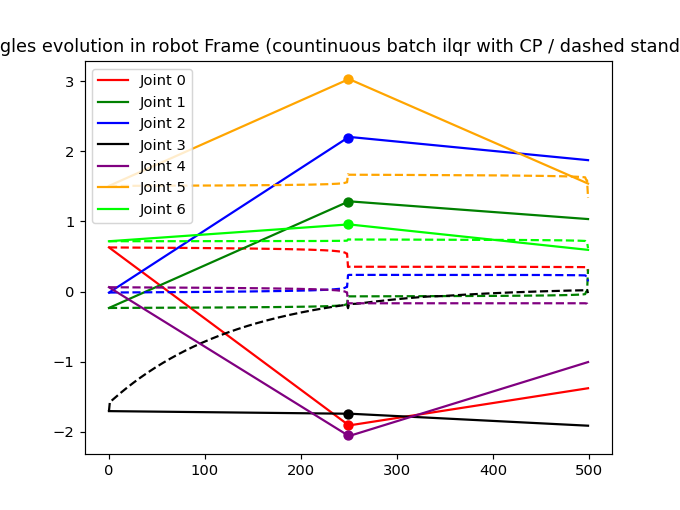

In [12]:
X2 = np.asarray(X2)

plt.figure()
plt.title('Joint angles evolution in robot Frame (countinuous batch ilqr with CP / dashed standard iLQR)')
c_map = ["red","green","blue","black","purple","orange","lime"]
for i in range(dof):
    plt.plot(X1[:,i],c=c_map[i],label="Joint "+str(i))
    plt.plot(X2[:,i],c=c_map[i],linestyle="dashed")
    plt.scatter(horizon//2-1,target_1[i],c=c_map[i])

plt.legend()